In [1]:
%load_ext autoreload
%load_ext dotenv
%autoreload 2
%dotenv 

In [2]:
import torch
from pathlib import Path
from tqdm.auto import tqdm
from torch.nn import Module
from torch.optim import Optimizer
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as t
from typing import Callable, Optional, Literal, Any

import sys; sys.path.append("../") if "../" not in sys.path else None
from viz.dataset_plots import plot_segmentation_samples

import logging
from lightning.pytorch.utilities import disable_possible_user_warnings # type: ignore
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)
disable_possible_user_warnings()

In [10]:
from datasets.inria import InriaLitData, InriaSegmentation, InriaHDF5, InriaImageFolder
# import pandas as pd

inria_kwargs = {
    "root" : Path.home() / "datasets" / "urban_footprint",
    "test_split": 0.2, "val_split": 0.1, "random_seed": 69,
    #"tile_size": (512, 512), "tile_stride": (512, 512),
    ##"shard_size_in_mb": 256 
}

scene_ds = InriaImageFolder(**inria_kwargs)
tile_ds = InriaImageFolder(**inria_kwargs, tile_size = (512, 512), tile_stride = (512, 512))
display(scene_ds.df.head())
display(tile_ds.df.head())


train scene dataset @ [/home/sambhav/datasets/urban_footprint]
train tiled dataset @ [/home/sambhav/datasets/urban_footprint]


,dataset_name,scene_idx,scene_name,tile_name,split,wbeg,wend,hbeg,hend,crs,xoff,yoff,xres,yres,image_path,mask_path,df_idx
0,inria,0,austin1.tif,austin1_0_5000_0_5000.tif,train,0,5000,0,5000,EPSG:26914,616500.0,3345000.0,0.3,-0.3,sup/images/austin1.tif,sup/masks/austin1.tif,0
1,inria,1,austin2.tif,austin2_0_5000_0_5000.tif,train,0,5000,0,5000,EPSG:26914,616500.0,3346500.0,0.3,-0.3,sup/images/austin2.tif,sup/masks/austin2.tif,1
2,inria,2,austin3.tif,austin3_0_5000_0_5000.tif,train,0,5000,0,5000,EPSG:26914,616500.0,3348000.0,0.3,-0.3,sup/images/austin3.tif,sup/masks/austin3.tif,2
3,inria,3,austin4.tif,austin4_0_5000_0_5000.tif,train,0,5000,0,5000,EPSG:26914,616500.0,3349500.0,0.3,-0.3,sup/images/austin4.tif,sup/masks/austin4.tif,3
4,inria,4,austin5.tif,austin5_0_5000_0_5000.tif,test,0,5000,0,5000,EPSG:26914,616500.0,3351000.0,0.3,-0.3,sup/images/austin5.tif,sup/masks/austin5.tif,4


,dataset_name,scene_idx,scene_name,tile_name,split,wbeg,wend,hbeg,hend,crs,xoff,yoff,xres,yres,image_path,mask_path,df_idx
0,inria,0,austin1.tif,austin1_0_512_0_512.tif,train,0,512,0,512,EPSG:26914,616500.0,3345000.0,0.3,-0.3,sup/images/austin1.tif,sup/masks/austin1.tif,0
1,inria,0,austin1.tif,austin1_512_1024_0_512.tif,train,512,1024,0,512,EPSG:26914,616653.6,3345000.0,0.3,-0.3,sup/images/austin1.tif,sup/masks/austin1.tif,1
2,inria,0,austin1.tif,austin1_1024_1536_0_512.tif,train,1024,1536,0,512,EPSG:26914,616807.2,3345000.0,0.3,-0.3,sup/images/austin1.tif,sup/masks/austin1.tif,2
3,inria,0,austin1.tif,austin1_1536_2048_0_512.tif,train,1536,2048,0,512,EPSG:26914,616960.8,3345000.0,0.3,-0.3,sup/images/austin1.tif,sup/masks/austin1.tif,3
4,inria,0,austin1.tif,austin1_2048_2560_0_512.tif,train,2048,2560,0,512,EPSG:26914,617114.4,3345000.0,0.3,-0.3,sup/images/austin1.tif,sup/masks/austin1.tif,4


In [ ]:
xoff_tile = xoff_scene + (xres * wbeg)

In [ ]:
#InriaSegmentation.write_to_hdf(
    #root = Path.home() / "datasets" / "urban_footprint",
    #target = Path.home() / "datasets" / "urban_footprint" / "file_write_test",
    #df = dataset_df
#)

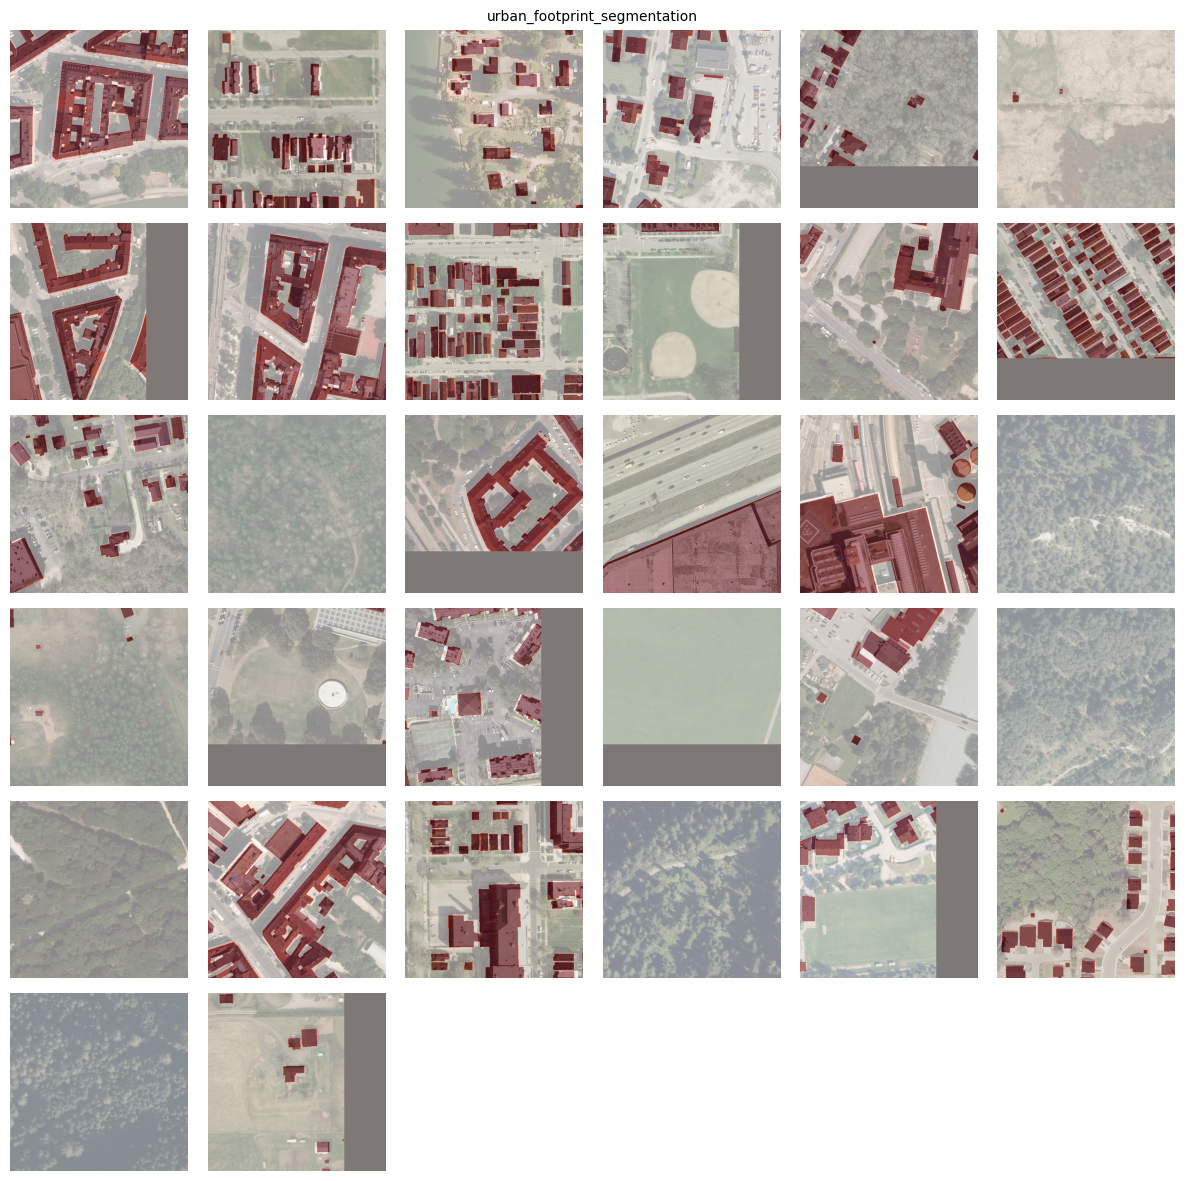

In [33]:
plot_segmentation_samples(ds, 32)

In [14]:
# TODO: Use Pytorch Profiler Here

from segmentation_models_pytorch import Unet
from datasets.inria import InriaImageFolder, InriaLitData, InriaHDF5

inria_kwargs = {
    "root" : Path.home() / "datasets" / "urban_footprint" / "inria.h5", 
    "split": "train",
    "test_split": 0.2, "val_split": 0.1, "random_seed": 69,
    "tile_size": (512, 512), "tile_stride": (512, 512)
}

dl = DataLoader(
    dataset = InriaHDF5(**inria_kwargs), 
    batch_size = 2,
    num_workers = 4, 
    #prefetch_factor = 10, 
    pin_memory = True, 
    shuffle = True,
    persistent_workers = True
)

unet = Unet("resnet18", classes=2, encoder_weights="imagenet") 
loss_fn = torch.nn.BCEWithLogitsLoss()
adam = torch.optim.Adam(unet.parameters(), lr = 1e-5)

def train_one_epoch(dataloader: DataLoader, model: Module, criterion: Module, optimizer: Optimizer, limit_train_batches: Optional[int] = None):
    if limit_train_batches is None:
        limit_train_batches = len(dataloader)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    for idx, batch in tqdm(enumerate(dataloader), total = limit_train_batches, unit = "steps"):
        if idx >= limit_train_batches:
            break
            
        images, masks = batch[0].to(device), batch[1].to(device)
        preds = model(images) 
        loss = criterion(preds.argmax(1).to(torch.float32), masks.argmax(1).to(torch.float32)).mean()
        loss.requires_grad_()
        #print(f"Step: {idx}, Loss: {loss}")
        #print(images.shape, images.dtype, images.min().item(), images.max().item())
        #print(masks.shape, masks.dtype, masks.min().item(), masks.max().item())
        #print(preds.shape, preds.dtype, preds.min().item(), preds.max().item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

train_one_epoch(dl, unet, loss_fn, adam, 500)
torch.cuda.empty_cache()

train tiled dataset @ [C:\Users\SambhavChandra\datasets\urban_footprint\inria.h5]


  0%|          | 0/6250 [00:00<?, ?steps/s]